In [1]:
#A couple utility functions to plot grayscale and RGB images
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Convolution

In [6]:
import numpy as np
from sklearn.datasets import load_sample_image

#load sample images
china = load_sample_image("china.jpg")/255
flower = load_sample_image("flower.jpg")/255
images = np.array([china,flower])
batch_size,height,width,channels = images.shape

#create 2 filters
filters = np.zeros(shape=(7,7,channels,2),dtype=np.float32)

# filters[:,3,:,0] = 1 #vertical line

filters[3, :, :, 1] = 1 #horizontal line
filters
# outputs = tf.nn.conv2d(images,filters,strides=1,padding="SAME")

# plt.imshow(outputs[0,:,:,1],cmap="gray") 
# plt.axis("off")
# plt.show()

array([[[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 

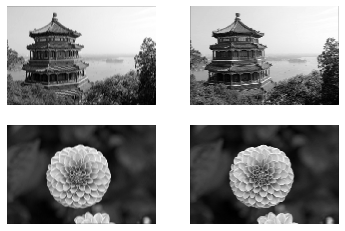

In [4]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plt.subplot(2,2,image_index*2+feature_map_index+1)
        plot_image(outputs[image_index,:,:,feature_map_index])
        
plt.show()

In [5]:
def crop(images):
    return images[150:230,100:270]

Saving figure china_original


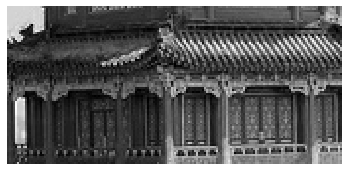

Saving figure china_vertical


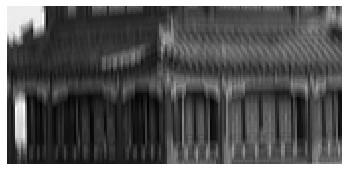

Saving figure china_horizontal


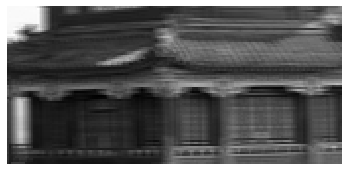

In [6]:
plot_image(crop(images[0,:,:,0]))
save_fig("china_original",tight_layout=False)
plt.show()

for feature_map_index,filename in enumerate(["china_vertical","china_horizontal"]):
    plot_image(crop(outputs[0,:,:,feature_map_index]))
    save_fig(filename,tight_layout=False)
    plt.show()

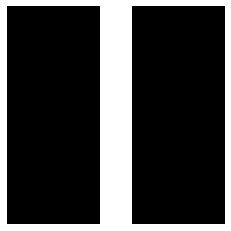

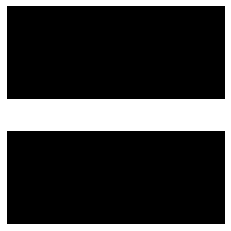

In [7]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

# Convolution Layer

Let's create a 2D convolutional layer, using keras.layers.Conv2D():

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2,kernel_size=7,strides=1,padding="SAME",
                          activation="relu",input_shape=outputs.shape)

Let's call this layer, passing it the two test images:

In [9]:
conv_outputs = conv(images)
conv_outputs.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 427, 640, 2])

The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since padding="SAME" and strides=1, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

Since the filters are initialized randomly, they'll initially detect random patterns. Let's take a look at the 2 output features maps for each image:

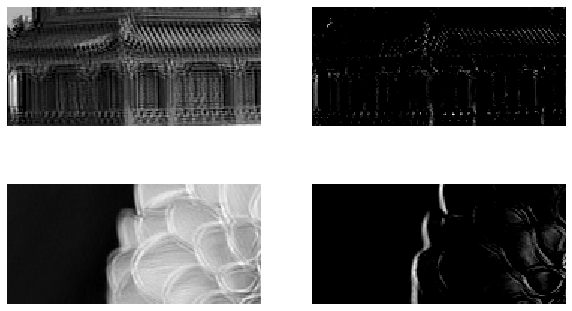

In [10]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()


Although the filters were initialized randomly, the second filter happens to act like an edge detector. Randomly initialized filters often act this way

If we want, we can set the filters to be the ones we manually defined earlier, and set the biases to zeros (in real life we will almost never need to set filters or biases manually, as the convolutional layer will just learn the appropriate filters and biases during training):

In [11]:
conv.set_weights([filters,np.zeros(2)])

In [12]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

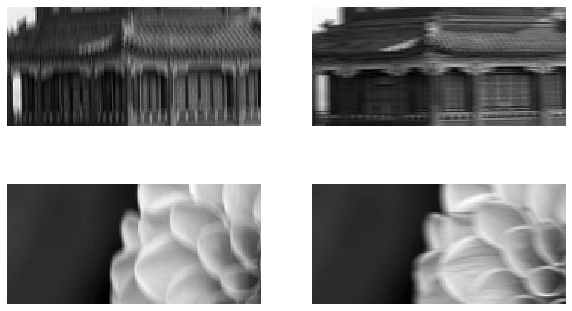

In [13]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

# Pooling Layer

Max Pooling

In [14]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [15]:
cropped_images = np.array([crop(image) for image in images],dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


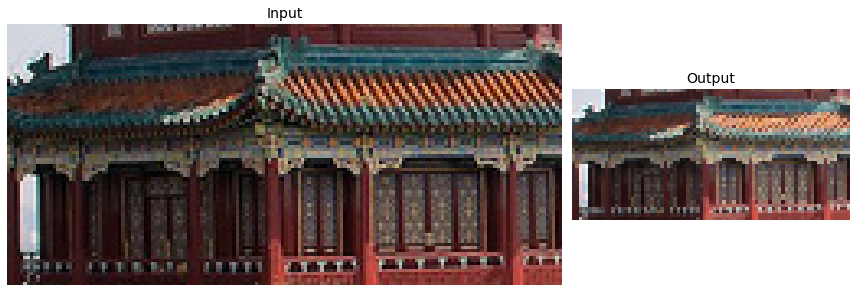

In [16]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

# Tackling Fashion MNIST with CNN

In [17]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [18]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 1467s 27ms/sample - loss: 0.7096 - accuracy: 0.7528 - val_loss: 0.4011 - val_accuracy: 0.8590
Epoch 2/10
55000/55000 [==============================] - 1661s 30ms/sample - loss: 0.4195 - accuracy: 0.8609 - val_loss: 0.3278 - val_accuracy: 0.8814
Epoch 3/10
55000/55000 [==============================] - 16630s 302ms/sample - loss: 0.3597 - accuracy: 0.8805 - val_loss: 0.3191 - val_accuracy: 0.8838
Epoch 4/10
55000/55000 [==============================] - 13731s 250ms/sample - loss: 0.3260 - accuracy: 0.8905 - val_loss: 0.2979 - val_accuracy: 0.8898
Epoch 5/10
47776/55000 [=========================>....] - ETA: 18:08 - loss: 0.3077 - accuracy: 0.8970